In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
# fetch the dataset.
digits, targets = load_digits(return_X_y=True)
digits = digits.astype(np.float32) / 255

digits_train, digits_test, targets_train, targets_test = train_test_split(digits, targets, random_state=0)

train_size = digits_train.shape[0]
test_size = digits_test.shape[0]

input_size = 8*8
classes_n = 10

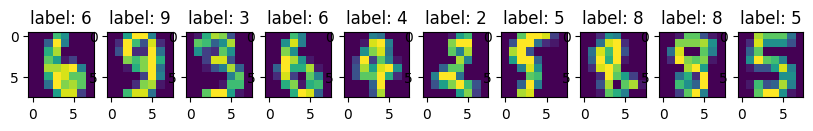

In [3]:
N = 10

sample_idx = np.random.choice(1797, N, replace=False)
digits_sample = digits[sample_idx]
targets_sample = targets[sample_idx]
f, ax  = plt.subplots(1,10, figsize=(10, 5))

for i in range(N):
    ax[i].imshow(digits_sample[i].reshape(8,8))
    ax[i].set_title('label: '+str(targets_sample[i]))


In [4]:
class Linear:
    def __init__(self, input_size, output_size):
        # Trainable parameters of the layer and their gradients
        self.thetas = np.random.randn(input_size, output_size) # the weight matrix of the layer (W)
        self.thetas_grads = np.empty_like(self.thetas) # gradient w.r.t. the weight matrix of the layer
        self.bias = np.random.randn(output_size) # bias terms of the layer (b)
        self.bias_grads = np.empty_like(self.bias) # gradient w.r.t. bias terms of the linear layer

    def forward(self, x): 
        # keep x for backward computation
        self.x = x
        output = np.matmul(x, self.thetas) + self.bias

        return output
    
    def backward(self, output_grad, learning_rate):
        """
        Calculate and return gradient of the loss w.r.t. the input of linear layer given the input x and the gradient 
        w.r.t output of linear layer. You should also calculate and update gradients of layer parameters.
        :param x: np.array, input tensor for linear layer;
        :param output_grad: np.array, grad tensor w.r.t output of linear layer;
        :return: np.array, grad w.r.t input of linear layer
        """
        
        ### BEGIN Solution (do not delete this comment)
        input_grad = np.dot(output_grad, self.thetas.T)
        self.thetas_grads = np.outer(self.x, output_grad)
        self.bias_grads = np.squeeze(output_grad)
        # >>> your solution here <<<
        self.step(learning_rate)

        ### END Solution (do not delete this comment!)
        
        return input_grad

    def step(self, learning_rate):
        self.thetas -= self.thetas_grads * learning_rate
        self.bias -= self.bias_grads * learning_rate
    
    def get_weights(self):
        return self.thetas, self.bias
    
    def set_weights(self, thetas, bias):
        self.thetas = thetas
        self.bias = bias


class LogisticActivation:
    def __init__(self):
        # the layer has no parameters
        pass 
        
    def sig(self, x):
        return 1/(1 + np.exp(-x))

    def forward(self, x):
        # keep o for backward computation
        self.o = self.sig(x)
        return self.o 


    def backward(self,  output_grad, learning_rate=None):
        """
        Calculate and return the gradient of the loss w.r.t. the input
        of logistic non-linearity (given input x and the gradient 
        w.r.t output of logistic non-linearity).
        
        :param x: np.array, input tensor for logistic non-linearity;
        :param output_grad: np.array, grad tensor w.r.t output of logistic non-linearity;
        :return: np.array, grad w.r.t input of logistic non-linearity
        
        """

        input_grad = output_grad * self.o *(1-self.o )

        
        return input_grad


class MLP:
    def __init__(self, input_size, hidden_layer_size, output_size):
        self.linear1 = Linear(input_size, hidden_layer_size)
        self.activation1 = LogisticActivation()
        self.linear2 = Linear(hidden_layer_size, output_size)
        
    def forward(self, x):
        h1 = self.linear1.forward(x)
        h1a = self.activation1.forward(h1)
        self.watchdog_absmax = np.max(np.abs(h1a))
        out = self.linear2.forward(h1a)
        
        return out

    def backward(self, output_grad, learning_rate):
        """
        Calculate and return the gradient of the loss w.r.t. the input of MLP given the input and the gradient 
        w.r.t output of MLP. You should also update gradients of paramerters of MLP layers.
        Hint - you should chain backward operations of modules you have already implemented. You may also
        need to calculate intermediate forward results.
        
        :param x: np.array, input tensor for MLP;
        :param output_grad: np.array, grad tensor w.r.t output of MLP;
        :return: np.array, grad w.r.t input of MLP
        """
 
        grad_l2 = self.linear2.backward(output_grad, learning_rate)
        grad_sig = self.activation1.backward(grad_l2)
        out = self.linear1.backward(grad_sig, learning_rate)

        return out
    
    def get_weights(self):

        return {"1 layer" : self.linear1.get_weights(),
                "2 layer" : self.linear2.get_weights()}
    
    
    def set_weights(self, w_h1, b_h1, w_h2, b_h2):
        self.linear1.set_weights(w_h1, b_h1)
        self.linear2.set_weights(w_h2, b_h2)

In [5]:
def softmax_crossentropy_with_logits(logits, reference_answers):

    true_answer = reference_answers
    reference_answers = np.zeros(10)
    reference_answers[true_answer] = 1

    exps = np.exp(logits-np.max(logits))
    softmax_probs = exps / np.sum(exps)
    
    loss = -np.sum(reference_answers*np.log(softmax_probs+1e-9))
    
    return loss

def grad_softmax_crossentropy_with_logits(logits, reference_answers):

    true_answer = reference_answers
    reference_answers = np.zeros(10)
    reference_answers[true_answer] = 1

    exps = np.exp(logits-np.max(logits))
    softmax_probs = exps / np.sum(exps)

    grad = (softmax_probs - reference_answers)

    return grad

In [6]:
np.random.seed(42)

mlp = MLP(input_size=input_size, hidden_layer_size=100, output_size=classes_n)

epochs_n = 100
learning_curve = [0] * epochs_n
test_curve = [0] * epochs_n

x_train = digits_train
x_test = digits_test
y_train = targets_train
y_test = targets_test

learning_rate = 1e-2

for epoch in range(epochs_n):
    
    y_pred = []

    for sample_i in range(train_size):
        x = x_train[sample_i].reshape((1, -1))
        target = np.array([y_train[sample_i]])

        logits = mlp.forward(x)
        
        loss = softmax_crossentropy_with_logits(logits, target)

        grads_input_sml = grad_softmax_crossentropy_with_logits(logits, target)

        mlp.backward(grads_input_sml, learning_rate)

        y_pred.extend(logits.argmax(1))

    if epoch % 10 == 0:
        
        y_pred_test = []

        for sample_i in range(test_size):
            x = x_test[sample_i].reshape((1, -1))
            target = np.array([y_test[sample_i]])
            
            logits = mlp.forward(x)
            y_pred_test.extend(logits.argmax(1))

        print('Starting epoch {}'.format(epoch), \
              ', Loss : {:.3}'.format(loss), \
              ', Accuracy on train: {:.3}'.format(accuracy_score(y_train, y_pred)), \
              ', Accuracy on test: {:.3}'.format(accuracy_score(y_test, y_pred_test)) )

Starting epoch 0 , Loss : 2.71 , Accuracy on train: 0.103 , Accuracy on test: 0.0667
Starting epoch 10 , Loss : 2.15 , Accuracy on train: 0.625 , Accuracy on test: 0.649
Starting epoch 20 , Loss : 1.55 , Accuracy on train: 0.821 , Accuracy on test: 0.807
Starting epoch 30 , Loss : 1.07 , Accuracy on train: 0.875 , Accuracy on test: 0.871
Starting epoch 40 , Loss : 0.742 , Accuracy on train: 0.9 , Accuracy on test: 0.889
Starting epoch 50 , Loss : 0.534 , Accuracy on train: 0.911 , Accuracy on test: 0.904
Starting epoch 60 , Loss : 0.399 , Accuracy on train: 0.92 , Accuracy on test: 0.924
Starting epoch 70 , Loss : 0.308 , Accuracy on train: 0.927 , Accuracy on test: 0.931
Starting epoch 80 , Loss : 0.245 , Accuracy on train: 0.929 , Accuracy on test: 0.931
Starting epoch 90 , Loss : 0.198 , Accuracy on train: 0.936 , Accuracy on test: 0.933


In [7]:
def MLP_accuracy(nn, y_test):
    
    y_test = np.array(y_test)
    y_pred_test = np.array([])

    for sample_i in range(y_test.size):
        x = x_test[sample_i].reshape((1, -1))

        logits = nn.forward(x)
        y_pred_test = np.append(y_pred_test, logits.argmax(1))

    return accuracy_score(y_test, y_pred_test)
    

In [8]:
logits = mlp.forward(x_test)
exps = np.exp(logits-np.max(logits))
softmax_probs = exps / np.sum(exps)

pred = np.zeros((y_test.shape[0]), dtype="int")

for idx, prob in enumerate(softmax_probs):
    pred[idx] = np.argmax(prob)

cm = confusion_matrix(y_true = y_test, y_pred = pred)
print(cm)

[[37  0  0  0  0  0  0  0  0  0]
 [ 0 39  0  0  0  0  2  0  0  2]
 [ 0  1 41  1  0  0  0  1  0  0]
 [ 0  0  0 43  0  0  0  0  1  1]
 [ 0  0  0  0 37  0  0  1  0  0]
 [ 0  0  0  0  0 46  0  0  0  2]
 [ 0  1  0  0  0  0 51  0  0  0]
 [ 0  0  0  0  0  0  0 48  0  0]
 [ 0  4  1  0  0  1  0  1 41  0]
 [ 0  0  0  4  0  2  0  0  1 40]]


In [43]:
w_1 = mlp.get_weights()['1 layer'][0]
b_1 = mlp.get_weights()['1 layer'][1]
w_2 = mlp.get_weights()['2 layer'][0]
b_2 = mlp.get_weights()['2 layer'][1]

for m in [w_1, b_1, w_2, b_2]:
    print(m.shape)
print('Accuracy on test, initial mlp: {:.4}'.format(MLP_accuracy(mlp, y_test)))

(64, 100)
(100,)
(100, 10)
(10,)
Accuracy on test, initial mlp: 0.94


In [125]:
class Linear_factorized:
    def __init__(self, input_size, output_size):
        # Trainable parameters of the layer and their gradients
        self.thetas = np.random.randn(input_size, output_size) # the weight matrix of the layer (W)
        self.thetas_grads = np.empty_like(self.thetas) # gradient w.r.t. the weight matrix of the layer
        self.bias = np.random.randn(output_size) # bias terms of the layer (b)
        self.bias_grads = np.empty_like(self.bias) # gradient w.r.t. bias terms of the linear layer

    def forward(self, x): 
        # keep x for backward computation
        
        self.scale_input = (np.max(np.abs(x))/(2**(8-1)-1))       
        self.x_qzed = np.clip(np.round(x/self.scale_input), -2**(8-1) , 2**(8-1)-1)
        output = (self.x_qzed.astype("int16") @ self.A.astype("int16") @ self.B.astype("int16").T) * (self.scale_w ** 2) * self.scale_input + self.bias * self.scale_b
        return output

    def get_weights(self):
        return self.scale_input, self.A, self.B, self.scale_w, self.bias, self.scale_b
    
    def set_weights(self, inp, w_pack, b_pack):
        self.scale_input = inp
        self.A = w_pack[0].astype("int8")
        self.B = w_pack[1].astype("int8")
        self.scale_w = w_pack[2]
        self.bias = b_pack[0].astype("int8")
        self.scale_b = b_pack[1]

class MLP_factorized:
    def __init__(self, input_size, hidden_layer_size, output_size):
        self.linear1 = Linear_factorized(input_size, hidden_layer_size)
        self.activation1 = LogisticActivation()
        self.linear2 = Linear_factorized(hidden_layer_size, output_size)
        
    def forward(self, x):
        h1 = self.linear1.forward(x)
        h1a = self.activation1.forward(h1)
        out = self.linear2.forward(h1a)
        return out
    
    def get_weights(self):
        return {"1 layer" : self.linear1.get_weights(),
                "2 layer" : self.linear2.get_weights()}
        
    def set_weights(self, in1, w1_pack, b1_pack, in2, w2_pack, b2_pack):
        self.linear1.set_weights(in1, w1_pack, b1_pack)
        self.linear2.set_weights(in2, w2_pack, b2_pack)

In [126]:
import numpy as np
import torch
from tensorly.decomposition import parafac

def quantization_forw(T,z,b,scale):
    T = np.clip(np.round(T/scale)+z,-2**(b-1),2**(b-1)-1)
    return T.int()

def quantization_back(T,z,scale):
    return scale * (T - z)

def ADMM(B, U, K, G, rank, scale):
    ro = torch.trace(G) / rank

    LL = G + ro * torch.eye(*G.size())
    L = torch.linalg.cholesky(LL)
    LL_inv = torch.cholesky_inverse(L)

    r = torch.inf
    s = torch.inf

    for _ in range(100):
    # while (r > 0.01) or (s > 0.01):
        # print(r, s)
        B_ = LL_inv @ (K + ro * (B + U)).T
        B0 = torch.clone(B)

        B = quantization_back(quantization_forw(B_.T - U, 0, 8, scale), 0, scale)
        U = U + B - B_.T

        r = torch.norm(B - B_.T, p='fro')**2 / torch.norm(B, p='fro')**2
        s = torch.norm(B - B0, p='fro')**2 / torch.norm(U, p='fro')**2
    return B, U


def e_quant(X, A, B):
    return torch.norm(X - A@B.T, p='fro')/torch.norm(X, p='fro')

def factorize(W, reduction_rate = 2):
    M,N = W.shape
    rank = round(M*N/(M + N)/reduction_rate)
    #W - должен быть просто numpy массивом
    # weights, factors = parafac(W, rank=rank)
    weights, factors = parafac(W, rank=np.min([M,N]))
    A = torch.from_numpy(factors[0])
    B = torch.from_numpy(factors[1])
    new_W = A@B.T

    W = torch.from_numpy(W)

    U_A = torch.zeros_like(A)
    U_B = torch.zeros_like(B)

    e_old = 0.
    e_new = e_quant(W,A,B)

    b=8
    #scale1 = (torch.max(A)-torch.min(A))/(2**b-1)
    #scale2 = (torch.max(B)-torch.min(B))/(2**b-1)
    #q_max = 9.89675982 * torch.mean(torch.abs(A - A.mean()))
    #scale2 = 2*q_max/(2**b-1)
    #q_max = 9.89675982 * torch.mean(torch.abs(B - B.mean()))
    #scale1 = 2*q_max/(2**b-1)
    q_max = 9.89675982 * torch.mean(torch.abs(W - W.mean()))
    # scale = 2*q_max/(2**b-1)

    scale = (torch.max(torch.abs(W))/(2**(8-1)-1))

    while torch.abs(e_new - e_old) > 0.01:
        # print(f'error: {torch.abs(e_new - e_old)}')
        K = W @ B
        G = B.T @ B
        A, U_A = ADMM(A, U_A, K, G, rank, scale)  
        
        K = W.T @ A
        G = A.T @ A
        B, U_B = ADMM(B, U_B, K, G, rank, scale)

        e_old = e_new
        e_new = e_quant(W,A,B)
    
    # print(f'error: {torch.abs(e_new - e_old)}')

    return new_W, A, B, scale

In [127]:
# now hardcode for int8

mlp_modified = MLP_factorized(input_size=input_size, hidden_layer_size=100, output_size=classes_n)

w_1 = torch.from_numpy(mlp.get_weights()['1 layer'][0])
new_w1, A_w1, B_w1, scale_w1 = factorize(w_1.numpy())
A_w1_int = (A_w1/scale_w1).int()
B_w1_int = (B_w1/scale_w1).int()
w1_pack = [A_w1_int.numpy(), B_w1_int.numpy(), scale_w1.numpy()]

b_1 = torch.from_numpy(mlp.get_weights()['1 layer'][1])
scale_b1 = (torch.max(torch.abs(b_1))/(2**(8-1)-1))
b1_int = quantization_forw(b_1, 0, 8, scale_b1)
b1_pack = [b1_int.numpy(), scale_b1.numpy()]

w_2 = torch.from_numpy(mlp.get_weights()['2 layer'][0])
new_w2, A_w2, B_w2, scale_w2 = factorize(w_2.numpy())
A_w2_int = (A_w2/scale_w2).int()
B_w2_int = (B_w2/scale_w2).int()
w2_pack = [A_w2_int.numpy(), B_w2_int.numpy(), scale_w2.numpy()]

b_2 = torch.from_numpy(mlp.get_weights()['2 layer'][1])
scale_b2 = (torch.max(torch.abs(b_2))/(2**(8-1)-1))
b2_int = quantization_forw(b_2, 0, 8, scale_b2)
b2_pack = [b2_int.numpy(), scale_b2.numpy()]


input_scale = (np.max(np.abs(x_train))/(2**(8-1)-1))
l2_input_scale = mlp.watchdog_absmax/(2**(8-1)-1)

mlp_modified.set_weights(input_scale, w1_pack, b1_pack, l2_input_scale, w2_pack, b2_pack)


In [128]:
mlp_modified.forward(x_train[0])

array([ 1.51151752, -0.24669025,  0.61271747,  0.38412863, -0.67242104,
       -1.87939557, -0.15523765, -1.08066435, -0.89635465, -0.63823596])

In [129]:
mlp.forward(x_train[0])

array([-2.96355181,  1.00562364,  6.82339377,  2.54897489, -4.32331601,
        0.21446757, -1.36363943, -1.29536591,  1.21605275, -2.12493598])

In [130]:
print('Accuracy on test, quantized mlp: {:.4}'.format(MLP_accuracy(mlp_modified, y_test)))

Accuracy on test, quantized mlp: 0.08222
